# **Generative Adversarial Network (GAN) Trained on Stanford Cars Dataset** #

## **Initial Setup** ##

In [1]:
!pip install torch
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## **External Libraries** ##

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import scipy.io as sio
import numpy as np
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision.transforms import Resize

## **Loading the Stanford Cars Dataset** ##

In [3]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip stanford-cars-dataset.zip -d stanford-cars-dataset/

Streaming output truncated to the last 5000 lines.
  inflating: stanford-cars-dataset/cars_train/cars_train/03145.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03146.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03147.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03148.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03149.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03150.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03151.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03152.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03153.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03154.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03155.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03156.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_train/03157.jpg  
  inflating: stanford-cars-dataset/cars_train/cars_t

## **Data Preprocessing** ##
- Converting to 64x64 size
- Converting to Grayscale

In [4]:
# Directories
train_input_dir = "./stanford-cars-dataset/cars_train/cars_train"
test_input_dir = "./stanford-cars-dataset/cars_test/cars_test"

# Transformations: Resize to 64x64, convert to grayscale, normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Custom Dataset to load images from directories
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure image is in RGB mode
        if self.transform:
            image = self.transform(image)
        return image, 0  # Return 0 as the label since we don't need it here

# Load datasets
train_dataset = CarsDataset(train_input_dir, transform=transform)
test_dataset = CarsDataset(test_input_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## **CNN Based Discriminator Architecture** ##

In [5]:
# Define Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.nonlin2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.nonlin3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.nonlin4 = nn.LeakyReLU(0.2)
        self.fc = nn.Linear(512 * 4 * 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = self.nonlin1(self.conv1(x))
        h = self.nonlin2(self.conv2(h))
        h = self.nonlin3(self.conv3(h))
        h = self.nonlin4(self.conv4(h))
        h = h.view(h.size(0), -1)  # Flatten
        out = self.sigmoid(self.fc(h))
        return out

This architecture uses a series of convolutional layers to progressively downsample the 64 x 64 input while extracting spatial features. This design is tailored to process higher-resolution images, ensuring effective feature extraction while maintaining computational efficiency for distinguishing real and fake samples.

### **Generator Architecture** ###

In [6]:
# Define Generator class
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 512 * 4 * 4)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.nonlin2 = nn.LeakyReLU(0.2)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.nonlin3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.nonlin4 = nn.LeakyReLU(0.2)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        h = h.view(h.size(0), 512, 4, 4)
        h = self.nonlin2(self.conv1(h))
        h = self.nonlin3(self.conv2(h))
        h = self.nonlin4(self.conv3(h))
        out = self.tanh(self.conv4(h))
        return out

### **GAN Training Loop (50 Epochs)** ###

In [7]:
# Training loop

# Set device (use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Hyperparameters ===
epochs = 50                 # Number of training epochs
z_dim = 100                 # Dimensionality of the latent space (noise vector size)
lr = 0.0002                 # Learning rate for both optimizers
beta1, beta2 = 0.5, 0.999   # Adam optimizer beta parameters

# Initialize models
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()  # Binary cross-entropy loss for adversarial training
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

# Lists to store loss values
g_losses = []  # Generator loss per epoch
d_losses = []  # Discriminator loss per epoch

# Training loop
for epoch in range(epochs):

    epoch_g_loss = 0  # Accumulator for generator loss in the current epoch
    epoch_d_loss = 0  # Accumulator for discriminator loss in the current epoch

    for batch_idx, (real_images, _) in enumerate(train_loader):  # Use train_loader for real data
        batch_size = real_images.size(0)  # Size of the current batch
        real_images = real_images.to(device)

        # === Train Discriminator ===
        real_labels = torch.ones(batch_size, 1).to(device)  # Labels for real images: 1
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Labels for fake images: 0

        # Loss on real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        # Loss on fake images
        z = torch.randn(batch_size, z_dim).to(device)  # Generate random noise (latent space)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())  # Detach to prevent updating generator
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()  # Zero the gradients
        d_loss.backward()  # Backpropagate the loss
        d_optimizer.step()  # Update discriminator parameters

        # === Train Generator ===
        z = torch.randn(batch_size, z_dim).to(device)  # Generate new noise
        fake_images = generator(z)  # Create fake images
        outputs = discriminator(fake_images)  # Get discriminator's predictions on fake images
        g_loss = criterion(outputs, real_labels)  # Generator tries to fool discriminator

        g_optimizer.zero_grad()  # Zero the gradients
        g_loss.backward()  # Backpropagate the loss
        g_optimizer.step()  # Update generator parameters

        # Accumulate losses
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

        # Print progress for every 100 steps
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Store average losses for the epoch
    g_losses.append(epoch_g_loss / len(train_loader))
    d_losses.append(epoch_d_loss / len(train_loader))

Epoch [1/50], Step [0/128], D Loss: 1.3835, G Loss: 0.6961
Epoch [1/50], Step [100/128], D Loss: 0.7213, G Loss: 3.6838
Epoch [2/50], Step [0/128], D Loss: 0.3361, G Loss: 5.3827
Epoch [2/50], Step [100/128], D Loss: 2.1325, G Loss: 7.4544
Epoch [3/50], Step [0/128], D Loss: 0.6436, G Loss: 2.4971
Epoch [3/50], Step [100/128], D Loss: 0.8432, G Loss: 1.9417
Epoch [4/50], Step [0/128], D Loss: 0.6435, G Loss: 1.9358
Epoch [4/50], Step [100/128], D Loss: 1.1817, G Loss: 1.7602
Epoch [5/50], Step [0/128], D Loss: 0.9588, G Loss: 2.1248
Epoch [5/50], Step [100/128], D Loss: 1.0743, G Loss: 1.9229
Epoch [6/50], Step [0/128], D Loss: 0.8177, G Loss: 1.8887
Epoch [6/50], Step [100/128], D Loss: 1.1151, G Loss: 1.3193
Epoch [7/50], Step [0/128], D Loss: 0.7332, G Loss: 2.5023
Epoch [7/50], Step [100/128], D Loss: 0.6367, G Loss: 3.1732
Epoch [8/50], Step [0/128], D Loss: 0.7888, G Loss: 2.1065
Epoch [8/50], Step [100/128], D Loss: 0.6917, G Loss: 2.0333
Epoch [9/50], Step [0/128], D Loss: 1.11

## **Results** ##

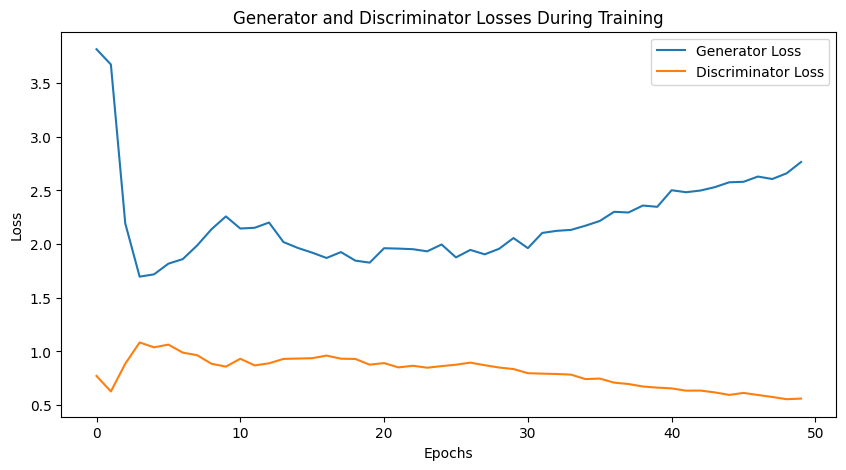

In [8]:
# === Plot Losses ===
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses During Training")
plt.legend()
plt.show()

### **Generating 20 Samples using the trained GAN** ###

In [9]:
def generate_samples(generator, n, z_dim=100, device='cpu'):
    """
    Generate 'n' images using the trained generator.

    Args:
    - generator (nn.Module): Trained generator model.
    - n (int): Number of images to generate.
    - z_dim (int): Dimensionality of the latent space (noise vector size). Default is 100.
    - device (str): Device to perform the computation on ('cpu' or 'cuda').

    Returns:
    - images (torch.Tensor): Generated images as a torch tensor of shape (n, 1, H, W).
    """
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        z = torch.randn(n, z_dim).to(device)  # Generate 'n' random latent vectors
        images = generator(z)  # Generate images from the latent vectors
        images = (images + 1) / 2  # Rescale images to the range [0, 1]
    return images

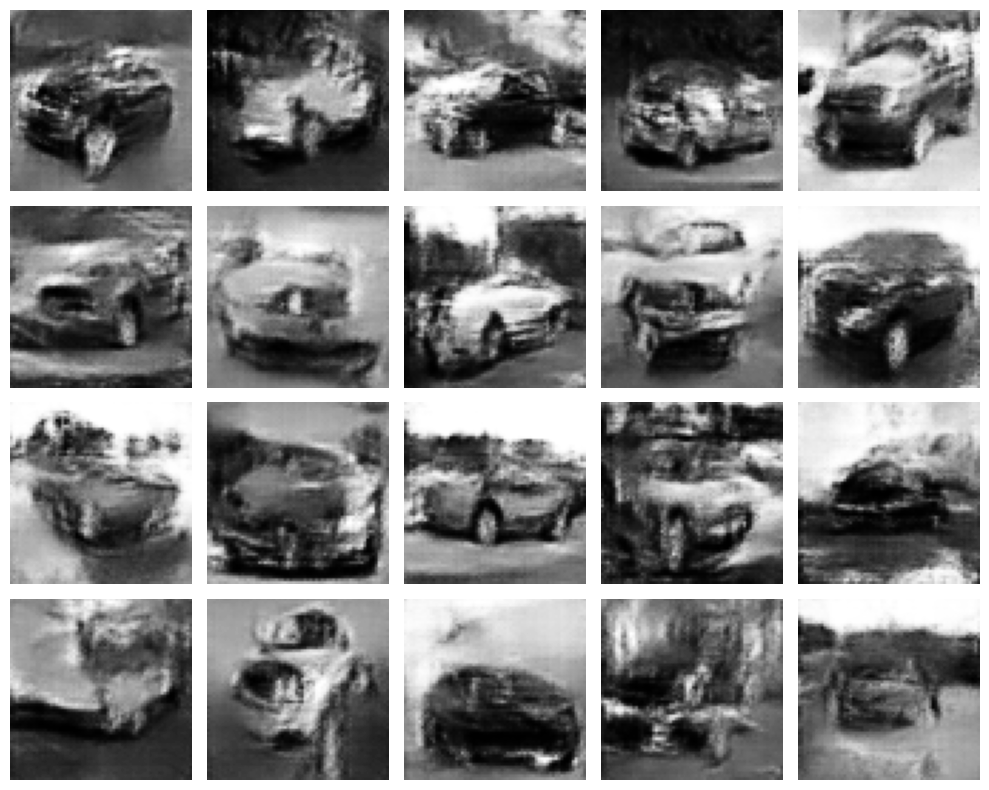

In [10]:
# Generate and display 20 images
n_samples = 20
generated_images = generate_samples(generator, n_samples, z_dim=z_dim, device=device)

# Plot the generated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))  # Arrange images in a 4x5 grid
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()